This code generates synthetic data based on different ditributions associated with a column

It also creates visualizations to compare the synthetic and real data

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from pandas.plotting import scatter_matrix

In [2]:
# Load the data from a CSV file
def load_data(filename):

    # Read the CSV file
    data = pd.read_csv(filename)
    # Drop the first column
    data = data.drop(data.columns[0], axis=1)
    # Drop the specified columns to get only numerical data
    nums = data.drop(['subject_id', 'hadm_id', 'charttime'], axis=1)

    return nums

# Calculate mean, variance, and NaN counts for each column
def calculate_stats(data):
    nan_counts = data.isnull().sum()
    smean = data.mean()
    svar = data.var()
    
    return nan_counts, smean, svar

# Fit different distributions to the data and select the best fit
def fit_distributions(data):
    # Define the distributions to be tested
    distributions = {
        'norm': stats.norm,
        'lognorm': stats.lognorm,
        'expon': stats.expon,
        'gamma': stats.gamma,
        'beta': stats.beta,
        'weibull_min': stats.weibull_min,
        't': stats.t,
        'f': stats.f,
    }
    
    results = {}
    test_results = {}
    for column in data.columns:
        column_data = data[column].dropna()
        _, smean, svar = calculate_stats(column_data)  # Extract only mean and variance
        
        best_fit = None
        best_p_value = -1
        test_result = []
        
        for name, distribution in distributions.items():
            try:
                if name in ['lognorm', 'gamma', 'beta', 'weibull_min', 't', 'chi2', 'f', 'pareto']:
                    params = distribution.fit(column_data)
                    ks_stat, p_value = stats.kstest(column_data, name, args=params)
                else:
                    params = distribution.fit(column_data)
                    ks_stat, p_value = stats.kstest(column_data, name, args=params)
                
                test_result.append((name, ks_stat, p_value))
                
                if p_value > best_p_value:
                    best_fit = (name, params)
                    best_p_value = p_value
            except Exception as e:
                print(f"Could not fit {name} distribution to {column}: {e}")
        
        results[column] = best_fit
        test_results[column] = test_result
    
    return results, test_results

# Generate synthetic data based on the best-fitting distributions
def generate_synthetic_data(data, fits):
    samples = len(data)
    synth_data = pd.DataFrame()
    
    for column in data.columns:
        dist_name, params = fits[column]
        distribution = getattr(stats, dist_name)
        synthetic_data = distribution.rvs(*params[:-2], loc=params[-2], scale=params[-1], size=samples)
        
        # Ensure all values are non-negative and cap GCS_Total at 15
        synthetic_data = np.clip(synthetic_data, a_min=0, a_max=None)
        if column == 'GCS Total':
            synthetic_data = np.clip(synthetic_data, a_min=0, a_max=15)
        
        # Introduce NaNs based on the original NaN distribution
        nan_counts = data[column].isnull().sum()
        nan_indices = np.random.choice(samples, nan_counts, replace=False)
        synthetic_data[nan_indices] = np.nan
        
        synth_data[column] = synthetic_data
    
    return synth_data

# Process a file and generate synthetic data
def process_file(filename):
    data = load_data(filename)
    fits, test_results = fit_distributions(data)
    synth_data = generate_synthetic_data(data, fits)

    return data, synth_data, test_results

# Compare statistics of real and synthetic data
def compare_stats(real_data, synth_data):
    real_nan_counts, real_mean, real_var = calculate_stats(real_data)
    synth_nan_counts, synth_mean, synth_var = calculate_stats(synth_data)
    
    print("Comparison of Real and Synthetic Data:\n")
    
    for column in real_data.columns:
        print(f"Column: {column}")
        
        print(f"Real Mean: {real_mean[column]}")
        print(f"Synthetic Mean: {synth_mean[column]}")
        print(f"Mean Difference: {real_mean[column] - synth_mean[column]}\n")
        
        print(f"Real Variance: {real_var[column]}")
        print(f"Synthetic Variance: {synth_var[column]}")
        print(f"Variance Difference: {real_var[column] - synth_var[column]}\n")
        
        print(f"Real NaN Count: {real_nan_counts[column]}")
        print(f"Synthetic NaN Count: {synth_nan_counts[column]}")
        print(f"NaN Count Difference: {real_nan_counts[column] - synth_nan_counts[column]}\n")
        print("-" * 50)

# Print the results of the distribution tests and the best choice
def print_test_results(test_results):
    for column, results in test_results.items():
        print(f"Column: {column}")
        for name, ks_stat, p_value in results:
            print(f"Distribution: {name}, KS Statistic: {ks_stat}, P-Value: {p_value}")
        
        # Determine the best fit
        best_fit = max(results, key=lambda item: item[2])
        print(f"Best Fit: {best_fit[0]}, KS Statistic: {best_fit[1]}, P-Value: {best_fit[2]}")
        print("-" * 50)

# Visualize correlation between real and synthetic data columns
def visualize_column_correlations(real_data, synth_data):
    # Ensure the columns match in both datasets
    assert real_data.columns.equals(synth_data.columns), "Columns do not match between real and synthetic data."

    correlations = {}
    for column in real_data.columns:
        correlations[column] = real_data[column].corr(synth_data[column])
    
    # Convert the correlations dictionary to a DataFrame
    corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
    
    # Plot the correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_df, annot=True, cmap="RdBu", center=0)
    plt.title('Correlation between Real and Synthetic Data Columns')
    plt.show()
    
    # Display the correlation coefficients table
    print("Correlation coefficients between Real and Synthetic data columns:")
    print(corr_df)

'''# Visualize scatter plots for comparing real and synthetic data
def visualize_scatter_plots(real_data, synth_data):
    # Ensure the columns match in both datasets
    assert real_data.columns.equals(synth_data.columns), "Columns do not match between real and synthetic data."
    
    # Create scatter plots for each column
    for column in real_data.columns:
        plt.figure(figsize=(8, 6))
        plt.scatter(real_data[column], synth_data[column], alpha=0.5, label=f'{column} (Real vs Synthetic)')
        plt.xlabel(f'Real {column}')
        plt.ylabel(f'Synthetic {column}')
        plt.title(f'Scatter Plot: Real vs Synthetic {column}')
        plt.legend()
        plt.grid(True)
        plt.show()'''


# Visualize scatter matrix for comparing real and synthetic data
def visualize_combined_scatter_matrix(real_data, synth_data):
    # Add a column to indicate real or synthetic data
    real_data['Type'] = 'Real'
    synth_data['Type'] = 'Synthetic'
    
    # Concatenate the datasets
    combined_data = pd.concat([real_data, synth_data], ignore_index=True)
    
    # Plot the scatter matrix
    sns.pairplot(combined_data, hue='Type', markers=['o', 's'])
    plt.suptitle('Combined Scatter Matrix for Real and Synthetic Data', y=1.02)
    plt.show()


In [ ]:
real_data, synth_data, test_results = process_file('final.csv')

print_test_results(test_results)

In [ ]:
compare_stats(real_data, synth_data)

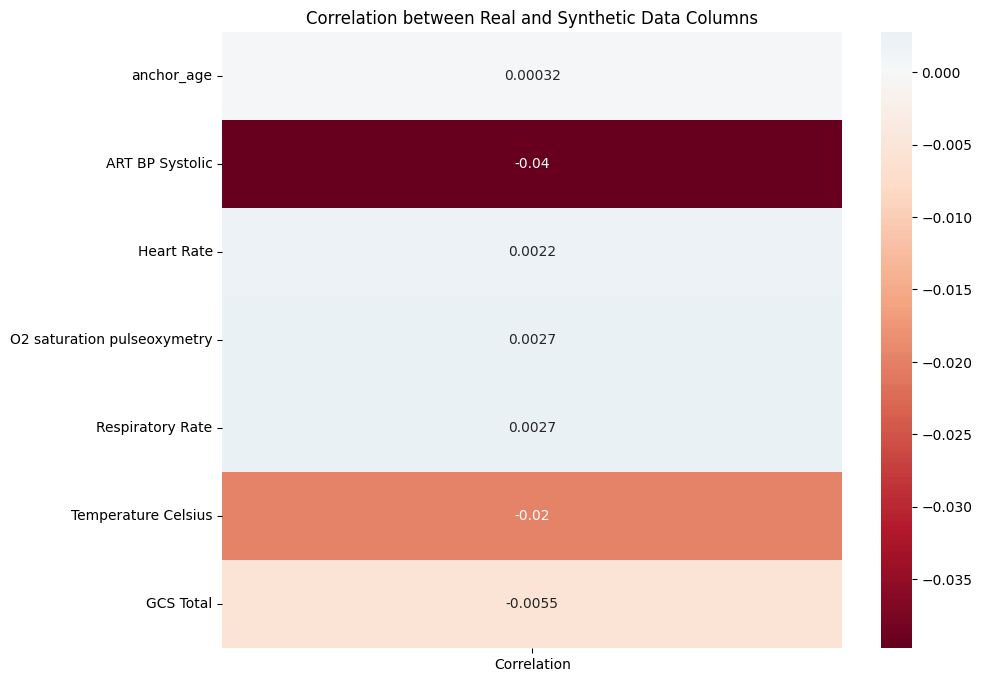

Correlation coefficients between Real and Synthetic data columns:
                             Correlation
anchor_age                      0.000316
ART BP Systolic                -0.039752
Heart Rate                      0.002203
O2 saturation pulseoxymetry     0.002720
Respiratory Rate                0.002745
Temperature Celsius            -0.019616
GCS Total                      -0.005451


In [5]:
visualize_column_correlations(real_data, synth_data)

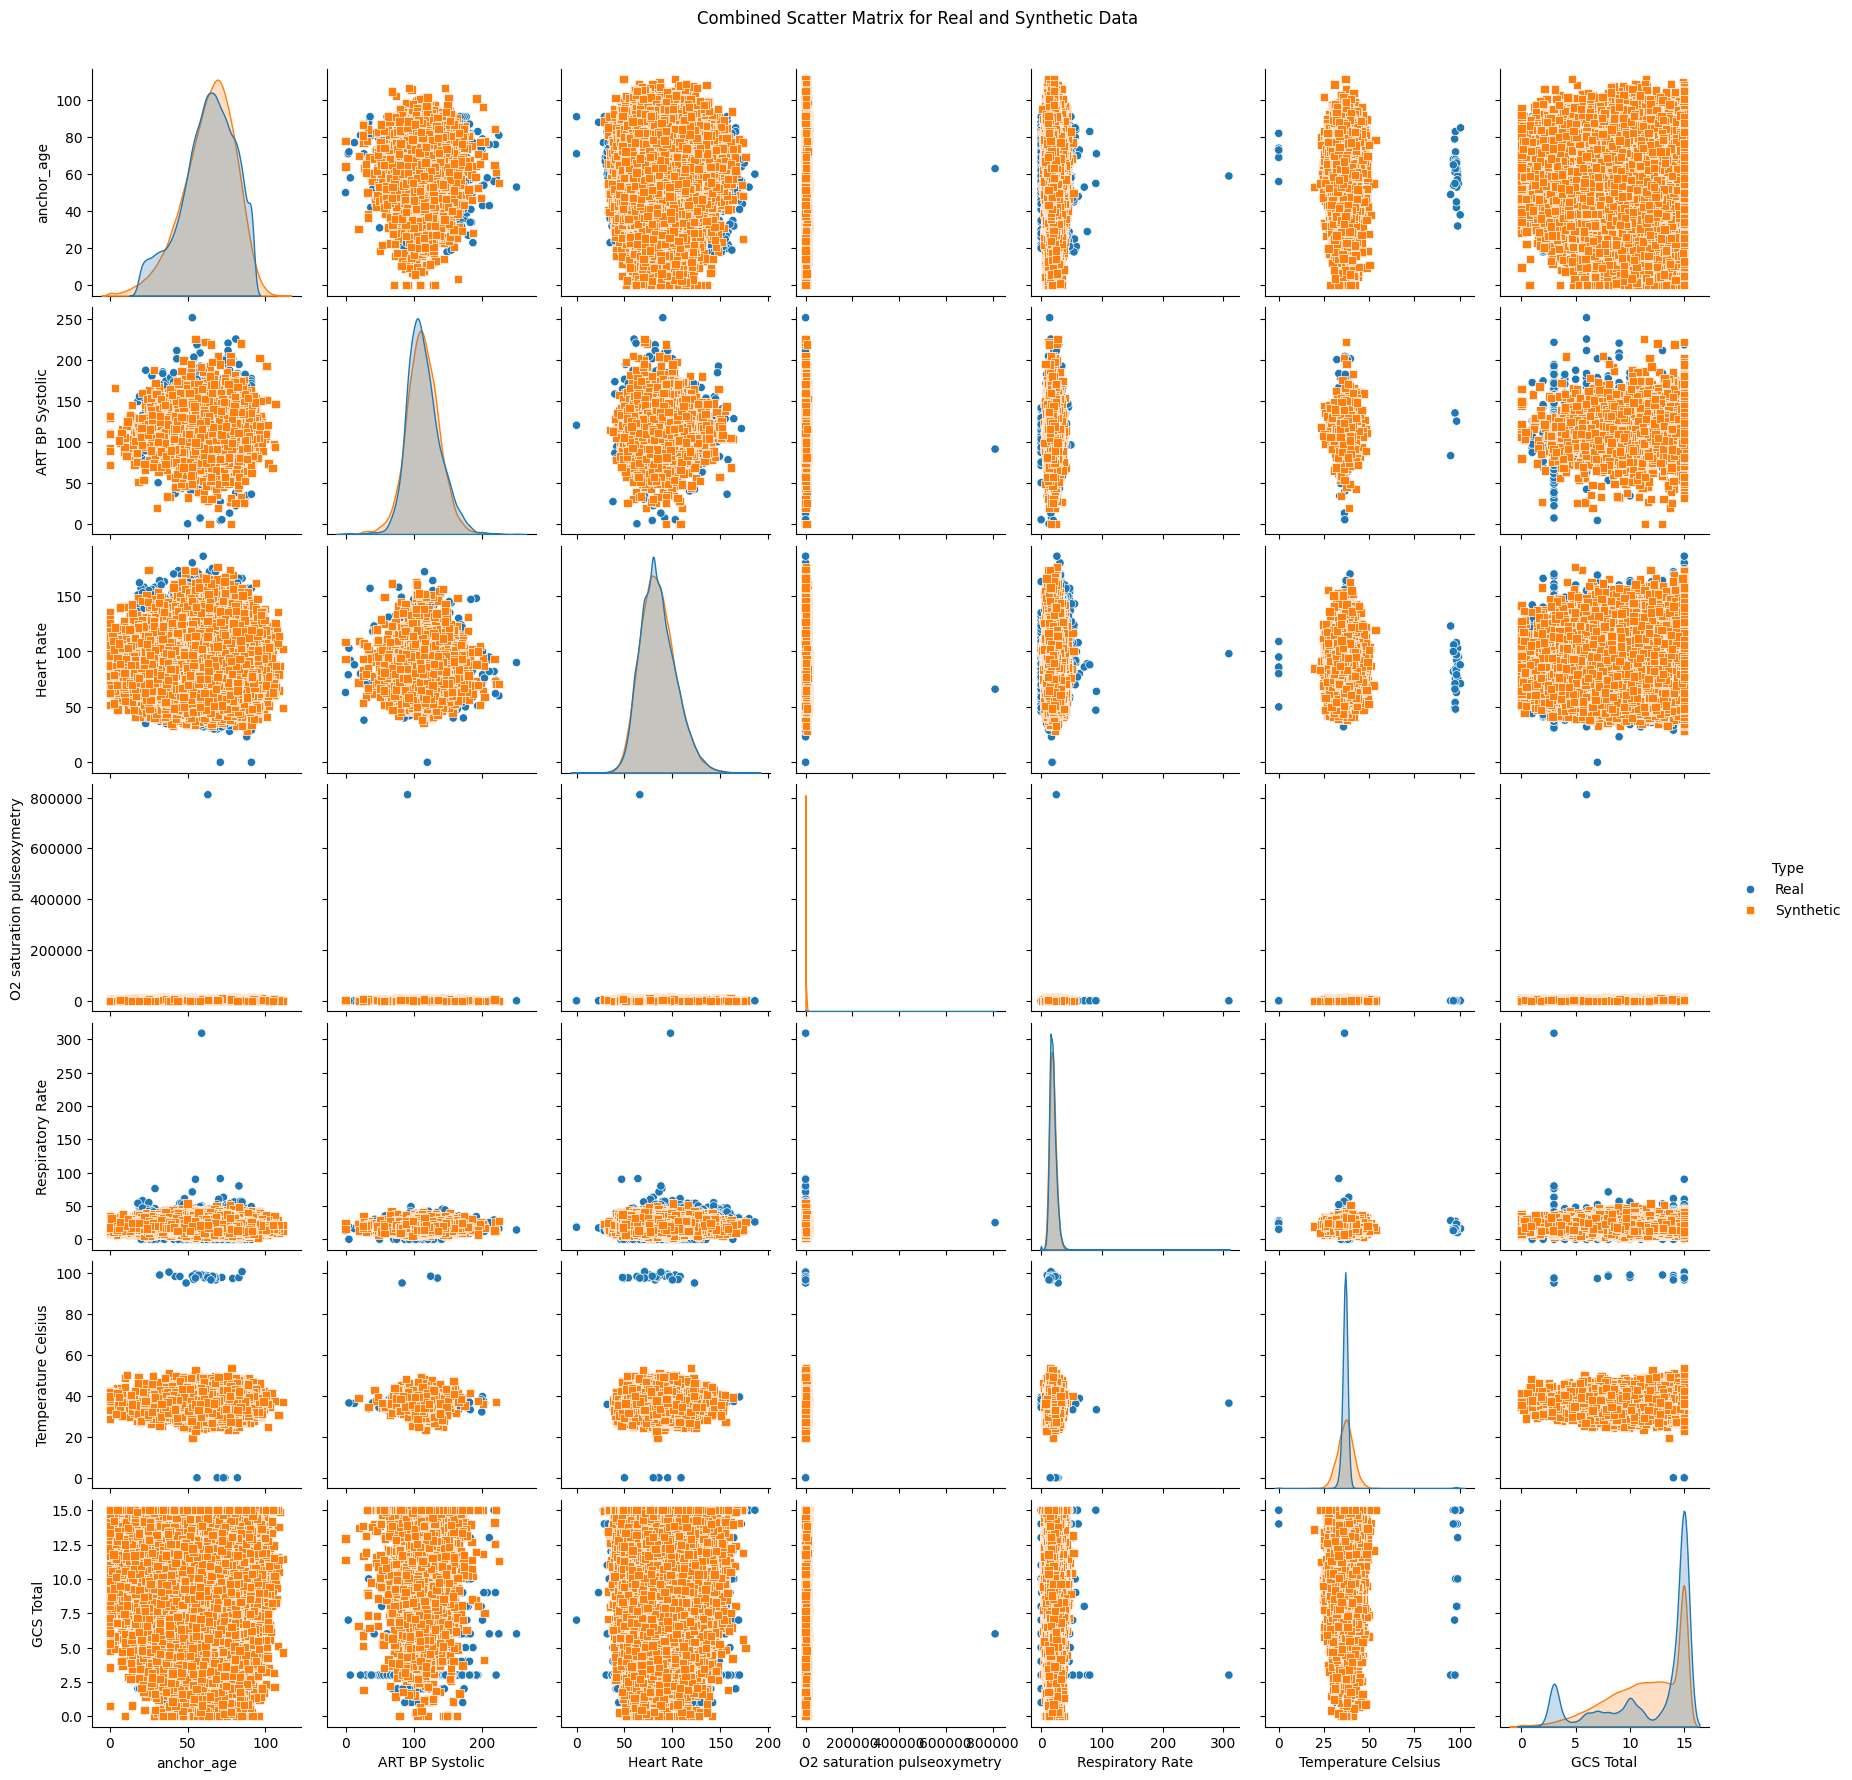

In [6]:
visualize_combined_scatter_matrix(real_data, synth_data)